# Run imports first

In [4]:

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import pickle
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Preprocessing 


Category check

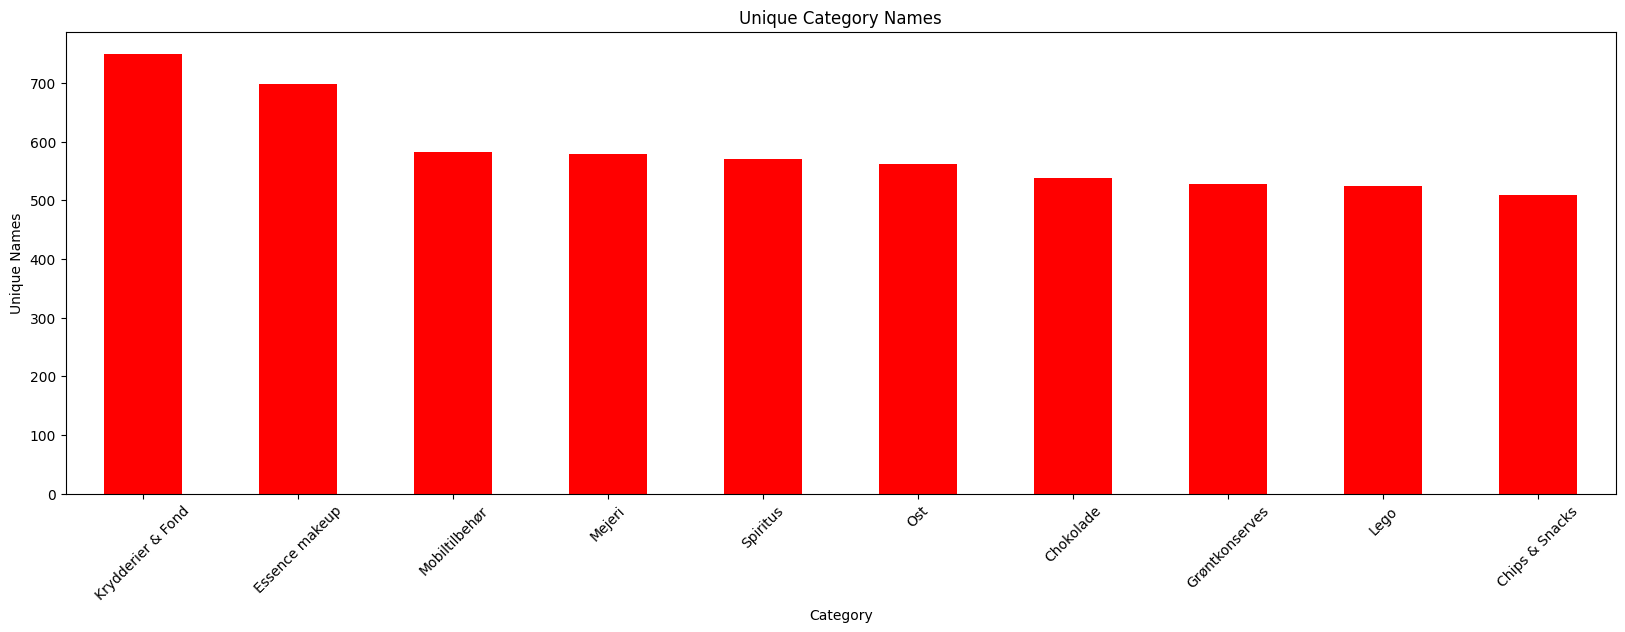

In [6]:
data = pd.read_csv('Data/Product data for Stibo.csv', delimiter=',', encoding='utf-8', usecols=['Category'])

# Here we just group the data by the 'Category' column and get the unique names of each category
category_names = data.groupby('Category')['Category'].unique()
# Here i get only the 10 most common appearances (too many to show)
top_10_categories = data['Category'].value_counts().head(10)


plt.figure(figsize=(20, 6))
top_10_categories.plot(kind='bar', color='red')

plt.title('Unique Category Names')
plt.xlabel('Category')
plt.ylabel('Unique Names')

plt.xticks(rotation=45)

plt.show()



Handling any missing values and handling duplicates

In [ ]:
# Check for missing values
print(data.isnull().sum())

# Fill or drop missing values
data.fillna(method='ffill', inplace=True)  # Forward fill as an example
# Or drop rows with missing values
data.dropna(inplace=True)
# Drop duplicate rows
data.drop_duplicates(inplace=True)


# Training without feature engineering (LabelEncoder)

In [ ]:

# Ensure the directory exists
os.makedirs("Model", exist_ok=True)

# Prepare features (X) and target (y)
X = dataU[['Product_Width', 'Product_Height', 'Product_Depth', 'Store_Name', 'Department']]
y = dataU['Category']

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Store_Name', 'Department'], drop_first=True)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    n_estimators=100,
    max_depth=9,
    learning_rate=0.1,
    colsample_bytree=0.8
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Save the model, label encoder, and feature names
joblib.dump(xgb_model, 'Model/xgb_model.pkl')
joblib.dump(le, 'Model/label_encoder.pkl')
joblib.dump(X.columns.tolist(), 'Model/feature_names.pkl')

print("Model, encoder, and feature names saved successfully!")

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Accuracy score
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred))


# Training without feature engineering (OneHotEncoder)

In [ ]:

# Ensure the directory exists
os.makedirs("Model", exist_ok=True)

# Prepare features (X) and target (y)
X = dataU[['Product_Width', 'Product_Height', 'Product_Depth', 'Store_Name', 'Department']]
y = dataU[['Category']]  # Target as a DataFrame for compatibility with OneHotEncoder

# One-hot encode the target variable
one_hot_encoder = OneHotEncoder(sparse_output=False)
y = one_hot_encoder.fit_transform(y)


# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Store_Name', 'Department'], drop_first=True)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Initialize the model
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    n_estimators=100,
    max_depth=9,
    learning_rate=0.1,
    colsample_bytree=0.8
)

# Train the model using the one-hot encoded target (adjusted for multi-class classification)
xgb_model.fit(X_train, y_train.argmax(axis=1), eval_set=[(X_val, y_val.argmax(axis=1))], verbose=True)

# Save the model, encoder, and feature names
joblib.dump(xgb_model, 'Model/xgb_model.pkl')
joblib.dump(one_hot_encoder, 'Model/one_hot_encoder.pkl')
joblib.dump(X.columns.tolist(), 'Model/feature_names.pkl')

print("Model, encoder, and feature names saved successfully!")

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Accuracy score
print("Test Set Accuracy:", accuracy_score(y_test.argmax(axis=1), y_pred))

# Classification report
print("\nClassification Report (Test Set):\n", classification_report(y_test.argmax(axis=1), y_pred))


# Training with feature engineering added

In [ ]:
# Prepare features (X) and target (y)
X = dataU[['Product_Width', 'Product_Height', 'Product_Depth']]

# Create new features
X['Product_Volume'] = X['Product_Width'] * X['Product_Height'] * X['Product_Depth']
X['Width_to_Height'] = X['Product_Width'] / (X['Product_Height'] + 1e-5)
X['Width_to_Depth'] = X['Product_Width'] / (X['Product_Depth'] + 1e-5)
X['Height_to_Depth'] = X['Product_Height'] / (X['Product_Depth'] + 1e-5)

X['Width_Height_Interaction'] = X['Product_Width'] * X['Product_Height']
X['Width_Depth_Interaction'] = X['Product_Width'] * X['Product_Depth']
X['Height_Depth_Interaction'] = X['Product_Height'] * X['Product_Depth']

X['Width_Bin'] = pd.cut(X['Product_Width'], bins=[0, 10, 20, 50, 100], labels=['Small', 'Medium', 'Large', 'Extra Large'])
X['Height_Bin'] = pd.cut(X['Product_Height'], bins=[0, 10, 20, 50, 100], labels=['Small', 'Medium', 'Large', 'Extra Large'])
X['Depth_Bin'] = pd.cut(X['Product_Depth'], bins=[0, 10, 20, 50, 100], labels=['Small', 'Medium', 'Large', 'Extra Large'])

# Convert bins to one-hot encoding
X = pd.get_dummies(X, columns=['Width_Bin', 'Height_Bin', 'Depth_Bin'], drop_first=True)

scaler = StandardScaler()
numeric_features = ['Product_Width', 'Product_Height', 'Product_Depth', 'Product_Volume',
                    'Width_to_Height', 'Width_to_Depth', 'Height_to_Depth',
                    'Width_Height_Interaction', 'Width_Depth_Interaction', 'Height_Depth_Interaction']

X[numeric_features] = scaler.fit_transform(X[numeric_features])

y = dataU['Category']

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Initialize the XGBClassifier
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    n_estimators=100,  # default number of estimators
    max_depth=9,       # default max depth
    learning_rate=0.1, # default learning rate
    colsample_bytree=0.8  # default value for colsample_bytree
)

# Train the model
xgb_model.fit(X_train, y_train)

# Save the model to a file
model_filename = 'Classification_Model_Final.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(xgb_model, file)

print(f"Model saved to {model_filename}")

# To load the model later
# with open(model_filename, 'rb') as file:
#     loaded_model = pickle.load(file)
#     print("Model loaded successfully")


# This is the xgb_model - The other under is Onnx

In [ ]:
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)


# Accuracy score
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred))
with open ('model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print ('Model saved')

# Model exploration (Experimental)


# ONNX model trial

In [ ]:
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)


# Accuracy score
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred))




with open ('model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print ('Model saved')


model = joblib.load('model.pkl')
onnx_model = convert_sklearn(model, initial_types=[('input', FloatTensorType([None, 1]))])
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

# Trying the Shelf Placement here

In [ ]:
# Load the dataset
data = pd.read_csv('Data/Product_data_with_new_columns.csv')

# Drop irrelevant columns
data = data.drop(columns=['Main_EAN', 'Product_Name'])

# Add feature engineering
data['Product_Volume'] = data['Product_Width'] * data['Product_Height'] * data['Product_Depth']
data['Width_to_Height'] = data['Product_Width'] / (data['Product_Height'] + 1e-5)
data['Width_to_Depth'] = data['Product_Width'] / (data['Product_Depth'] + 1e-5)
data['Height_to_Depth'] = data['Product_Height'] / (data['Product_Depth'] + 1e-5)

# Bin features and convert to categorical
data['Width_Bin'] = pd.cut(data['Product_Width'], bins=[0, 10, 20, 50, 100], labels=['Small', 'Medium', 'Large', 'Extra Large'])
data['Height_Bin'] = pd.cut(data['Product_Height'], bins=[0, 10, 20, 50, 100], labels=['Small', 'Medium', 'Large', 'Extra Large'])
data['Depth_Bin'] = pd.cut(data['Product_Depth'], bins=[0, 10, 20, 50, 100], labels=['Small', 'Medium', 'Large', 'Extra Large'])

# One-hot encode categorical features
data = pd.get_dummies(data, columns=['Width_Bin', 'Height_Bin', 'Depth_Bin', 'Product Packaging', 'Store_Name', 'Department'], drop_first=True)

# Convert 'ShelfLife' to numeric using Label Encoding
shelflife_encoder = LabelEncoder()
data['ShelfLife'] = shelflife_encoder.fit_transform(data['ShelfLife'])

# Ensure all one-hot encoded columns are numeric
for col in data.select_dtypes(include=['bool']).columns:
    data[col] = data[col].astype(int)

# Encode target variable (Category)
label_encoder = LabelEncoder()
data['Category'] = label_encoder.fit_transform(data['Category'])

# Save label encoder for later use
joblib.dump(label_encoder, 'shelf_model_label_encoder.pkl')

# Debugging step: Ensure all columns are numeric
non_numeric_cols = data.select_dtypes(exclude=['number']).columns.tolist()
if non_numeric_cols:
    raise ValueError(f"Non-numeric columns found: {non_numeric_cols}")

# Select relevant features
features = [
    'Product_Width', 'Product_Height', 'Product_Depth', 'Price', 
    'ShelfLife', 'Brand', 'Product_Volume', 'Width_to_Height', 
    'Width_to_Depth', 'Height_to_Depth'
] + [col for col in data.columns if 'Bin_' in col or 'Product_Packaging' in col or 'Store_Name' in col or 'Department' in col]

# Ensure all selected columns exist
missing_features = [f for f in features if f not in data.columns]
if missing_features:
    raise ValueError(f"Missing features: {missing_features}")

X = data[features]
y = data['Category']  # Now numeric

# Standardize only numerical features
numeric_features = ['Product_Width', 'Product_Height', 'Product_Depth', 'Price', 
                    'ShelfLife', 'Product_Volume', 'Width_to_Height', 
                    'Width_to_Depth', 'Height_to_Depth']
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Save feature names and scaler for later use
joblib.dump(list(X.columns), 'shelf_model_features.pkl')
joblib.dump(scaler, 'shelf_model_scaler.pkl')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Decision Tree Classifier
model = DecisionTreeClassifier(max_depth=9, random_state=42)
model.fit(X_train, y_train)

# # Save the trained model
# joblib.dump(model, 'shelf_model.pkl')

# Test the model
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Sample predictions
sample_input = X_test.iloc[:5]
predicted = model.predict(sample_input)
predicted_categories = label_encoder.inverse_transform(predicted)
print("\nSample Predictions:")
for i, pred in enumerate(predicted_categories):
    print(f"Input: {sample_input.iloc[i].to_dict()}, Predicted Shelf: {pred}")


# Shelf placement test without new columns, only original ones

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess data
data = pd.read_csv('Data/Product_data_with_new_columns.csv')

# Clean data
data['Product_Name'] = data['Product_Name'].str.strip()
data['Product_Name'] = data['Product_Name'].str.replace('*', '', regex=False)

numeric_columns = ['Product_Width', 'Product_Height', 'Product_Depth', 'Price']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data = data.dropna(subset=numeric_columns)

data['Product_Volume'] = data['Product_Width'] * data['Product_Height'] * data['Product_Depth']
data['Width_to_Height'] = data['Product_Width'] / (data['Product_Height'] + 1e-5)
data['Width_to_Depth'] = data['Product_Width'] / (data['Product_Depth'] + 1e-5)
data['Height_to_Depth'] = data['Product_Height'] / (data['Product_Depth'] + 1e-5)

# Select features and target
features = [
    'Product_Width', 'Product_Height', 'Product_Depth', 'Price', 
    'Product_Volume', 'Width_to_Height', 'Width_to_Depth', 'Height_to_Depth'
]
X = data[features]
y = data['Category']

# Encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)  # Convert to one-hot encoding

# Save label encoder for later use
import joblib
joblib.dump(label_encoder, 'category_nn_label_encoder.pkl')

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Save the scaler
joblib.dump(scaler, 'category_nn_scaler.pkl')

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')  # Number of classes = y_train.shape[1]
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy:.2f}")

# # Save the model
# model.save('category_nn_model.h5')

# Sample prediction
sample_input = X_val[:5]
predicted = model.predict(sample_input)
predicted_categories = label_encoder.inverse_transform(predicted.argmax(axis=1))
print("\nSample Predictions:")
for i, pred in enumerate(predicted_categories):
    print(f"Input: {sample_input[i]}, Predicted Category: {pred}")
